In [28]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

load_dotenv()

True

In [29]:
llm = init_chat_model('google_genai:gemini-2.5-flash')

E0000 00:00:1759842859.439767  100369 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [30]:
class ReviewResponseState(TypedDict):
  review_text: str
  emotion: Literal['positive', 'negative']
  response: str  
  diagnosis: str

In [31]:
class EmotionSchema(BaseModel):
  emotion: Literal['positive', 'nagative'] = Field(description='this is the emotion of the reveiw')
  
  
llm_struc = llm.with_structured_output(EmotionSchema)

In [32]:
def check_emotion(state: ReviewResponseState):
  
  prompt = f"this is the review of my product tell me what is the emotion of the customer is it positive or nagative, just reply in one word \n\n review: {state['review_text']}"
  
  response = llm_struc.invoke(prompt)
  
  return {'emotion': response.emotion}

In [38]:
def generate_reply(state: ReviewResponseState):
  
  prompt = f"you are replying to the customer for the {state['emotion']} response of the product here is the review, just write me appropriate reply \n review: {state['review_text']}"
  
  response = llm.invoke(prompt)
  
  return {'response': response.content}

In [34]:
def run_diagnosis(state: ReviewResponseState):
  
  prompt = f"this is the reivew from the customer can you analyse what went wrong here \n reivew: {state['review_text']}"
  
  response = llm.invoke(prompt)
  
  return {'diagnosis': response.content}

In [35]:
def do_check_emotion(state: ReviewResponseState) -> Literal['run_diagnosis', 'generate_reply']:
  
  if state['emotion'] == 'negative':
    return 'run_diagnosis'
  else:
    return 'generate_reply'

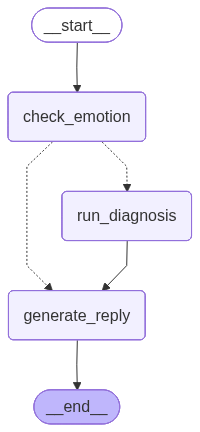

In [39]:
graph = StateGraph(ReviewResponseState)

graph.add_node('check_emotion', check_emotion)
graph.add_node('generate_reply', generate_reply)
graph.add_node('run_diagnosis', run_diagnosis)

graph.add_edge(START, 'check_emotion')
graph.add_conditional_edges('check_emotion', do_check_emotion)
graph.add_edge('run_diagnosis','generate_reply')
graph.add_edge('generate_reply', END)

workflow = graph.compile()

graph.compile()

In [40]:
init_state = {'review_text': "i bought this two years ago and it stopped working after 1 month"}


final_state = workflow.invoke(init_state)

final_state

{'review_text': 'i bought this two years ago and it stopped working after 1 month',
 'emotion': 'nagative',
 'response': 'Dear [Customer Name, if known, otherwise "Valued Customer"],\n\nWe\'re truly sorry to hear that your product stopped working after just one month, and we sincerely apologize for the frustration and disappointment this must have caused, especially given that you purchased it two years ago.\n\nWhile this review is from some time ago, a product failing so soon after purchase is certainly not the experience we want our customers to have, nor does it reflect the quality standards we aim for.\n\nEven though it\'s been a while, we\'d still like to see if there\'s anything we can do to assist or understand what might have happened. Could you please provide us with more details about the product (model name, type) and if you happen to have your order number or any purchase details from that time?\n\nPlease reach out to our customer support team directly at [Your Customer Ser